## Vector Autoregression (VAR)

กลุ่ม default lib

In [242]:
import numpy as np
import pandas as pd
from pathlib import Path

In [243]:
import datetime
import calendar

In [244]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

In [245]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tools.eval_measures import rmse, aic

ประกาศ methods

In [246]:
def split_data(df, split_date):
    return df[df.index <= split_date].copy(), \
           df[df.index >=  split_date].copy()

In [247]:
def z_standardization(df_col):
    for col in df_col.columns:
        col_zscore = col + '_ZS'
        df_col[col_zscore] = (df_col[col] - df_col[col].mean())/df_col[col].std(ddof=0)
    for col in df_col.columns:
        if not col.endswith('_ZS'):
            df_col.drop(col, axis=1,inplace = True)
    return df_col

In [248]:
def add_months(sourcedate, months):
    sourcedate = datetime.datetime.strptime(sourcedate, "%Y-%m-%d")
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day).strftime('%Y-%m-%d')

In [249]:
def set_df_output(df, monthList):
    df = pd.DataFrame(df, columns = ['NG CONS EGAT', 'NG CONS GSP','NG CONS IPP', 'NG CONS Industry', 'NG CONS NGV', 'NG CONS SPP',
       'NG PRD Domestic', 'NG PRD Import', 'POWGEN DEDP','POWGEN EGAT', 'POWGEN IPP', 'POWGEN Import', 'POWGEN SPP', 'POWGEN VSPP'])
    df.insert(loc=0, column='DS', value=monthList)
    df.set_index('DS', append=True, inplace=True)
    df.index.names = ['seqID', 'DS']
    df = df.reset_index(level=['seqID'])
    df.drop('seqID', axis=1,inplace = True)
    return df

In [276]:
def custom_plot_var_forc_from_df(prior, forc, err_upper, err_lower, actual,
                  index=None, names=None, plot_stderr=True, plot_actual=False, legend_options=None):

    fig = plt.figure(figsize=(20, 8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = plt.subplot()
    
    lagConnect = []
    lagConnect.append(prior.index[-1])
    lagConnect.extend(list(forc.index))
    
    lagConnect2 = []
    lagConnect2.append(prior.index[-1])
    lagConnect2.extend(list(actual.index))

    ax.plot(prior.index[-48:], prior[names][-48:], 'k', label='Observed (1989-2008)', marker='o')
    ax.plot(lagConnect, np.r_[prior[names][-1], forc[names]], 'r--', label='Forecast', marker='+')
    
    if plot_actual:
        ax.plot(lagConnect2, np.r_[prior[names][-1], actual[names]], 'b', marker='o', label='2019 Actual (8 months)')

    if plot_stderr:
        ax.plot(err_upper.index, err_upper[names], 'lightcoral', ls='-.', label='Forecast STD err (alpha 0.05)', marker='+')
        ax.plot(err_lower.index, err_lower[names], 'lightcoral', ls='-.', marker='+')

    if names is not None:
        ax.set_title(names)

    if legend_options is None:
        legend_options = {"loc": "upper left"}
    ax.legend(**legend_options)
    ax.grid(color='k', linestyle='--', linewidth=0.5)
    plt.xlabel('datetime')
    plt.ylabel('NG Consumption (MMSCFD)')
    plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
    return fig

In [251]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    '''
        Perform ADFuller to test for Stationarity of given series and print report
    '''
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [457]:
def invert_transformation(df, df_forecast, second_diff=False):
    '''
        Revert back the differencing to get the forecast to original scale.
    '''
    df_fc = df_forecast.copy()
    columns = df.columns
    for col in columns:        
        if second_diff:
            df_fc[str(col)] = (df[col].iloc[-1] - df[col].iloc[-2]) + df_fc[str(col)].cumsum()
        else:
            df_fc[str(col)] = df[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [253]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                                       # ME
    mae = np.mean(np.abs(forecast - actual))                         # MAE
    mpe = np.mean((forecast - actual)/actual)                        # MPE
    rmse = np.mean((forecast - actual)**2)**.5                     # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                            # corr
    return({'MAPE':mape, 'ME':me, 'MAE': mae, 'MPE': mpe, 'RMSE':rmse, 'CORR':corr})

Create dataframe
- Split and Graph Train & Test data

In [482]:
root = Path('aggregated_data')
joinData_file = 'aggregate_data.csv'   # Original aggregate file
joinData_df = pd.read_csv(root / joinData_file,index_col=0)
joinData_df.sort_index(inplace=True)

In [519]:
joinData2_file = 'book1.csv'   # 2019 aggregate file
joinData2_df = pd.read_csv(root / joinData2_file,index_col=0)
joinData2_df.sort_index(inplace=True)

In [484]:
train, test = split_data(joinData_df, '2008-01-31')

### Feature test

In [485]:
for name, column in test.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "NG CONS EGAT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8171
 No. Lags Chosen       = 12
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.814. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "NG CONS GSP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7216
 No. Lags Chosen       = 2
 Critical value 1%     = -3.482
 Critical value 5%     = -2.884
 Critical value 10%    = -2.579
 => P-Value = 0.42. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "NG CONS IPP" 
    -----------------------------------------------
 Null Hypothesi

### Drop some unwant feature

In [486]:
#train = train.fillna(0)
#test = test.fillna(0)

In [489]:
# Remove trend
test_noTrend = test.diff().dropna()
joinData2_df = joinData2_df.diff().dropna()

In [490]:
for name, column in test_noTrend.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "NG CONS EGAT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2493
 No. Lags Chosen       = 11
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.0173. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "NG CONS GSP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8591
 No. Lags Chosen       = 5
 Critical value 1%     = -3.484
 Critical value 5%     = -2.885
 Critical value 10%    = -2.579
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "NG CONS IPP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Sign

In [ ]:
#train.drop('POWGEN DEDP',axis=1,inplace=True)
#train.drop('NG CONS NGV',axis=1,inplace=True)
#train.drop('POWGEN VSPP',axis=1,inplace=True)

In [ ]:
#del test['POWGEN DEDP']
#del test['NG CONS NGV']

In [ ]:
#train = z_standardization(train)    # VSPP has NaN Value make VAR() Error
#test = z_standardization(test)      # VSPP hasn't NaN Value

In [491]:
proj_forc = 24
lags=5

### Fit the model

In [492]:
'''
Parameters
    ----------
    endog : array_like
        2-d endogenous response variable. The independent variable.
    exog : array_like
        2-d exogenous variable.
'''
model = VAR(endog=test_noTrend,freq='M')

In [493]:
'''
Information criterion to use for VAR order selection.
   "aic" : Akaike
   "ct" - constant and trend
'''
m_fit = model.fit(maxlags=lags, ic='aic', trend='ct')

In [494]:
try:
    for i in range(1,10):
        m_fit_testLag = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', m_fit_testLag.aic)
        print('BIC : ', m_fit_testLag.bic)
        print('FPE : ', m_fit_testLag.fpe)
        print('HQIC: ', m_fit_testLag.hqic, '\n')
except Exception:
    print(Exception)

Lag Order = 1
AIC :  112.9473212200655
BIC :  117.57949225541684
FPE :  1.1446570006652843e+49
HQIC:  114.82952710524206 

Lag Order = 2
AIC :  112.393961081415
BIC :  121.3946109742122
FPE :  7.237318991918761e+48
HQIC:  116.05110734374338 

Lag Order = 3
AIC :  112.25542119391801
BIC :  125.66887602891495
FPE :  8.258631785219692e+48
HQIC:  117.70537637424827 

Lag Order = 4
AIC :  111.80523912407958
BIC :  129.67658790355955
FPE :  9.434684550967655e+48
HQIC:  119.06615249270459 

Lag Order = 5
AIC :  110.7271285515753
BIC :  133.10224137308143
FPE :  9.849827271683901e+48
HQIC:  119.81743564873449 

Lag Order = 6
AIC :  108.41877798916212
BIC :  135.34432476828002
FPE :  7.923924477199844e+48
HQIC:  119.35720627643111 

Lag Order = 7
AIC :  102.64027297992477
BIC :  134.16374273741332
FPE :  1.4880894648341485e+48
HQIC:  115.44584760323737 

Lag Order = 8
<class 'Exception'>


In [495]:
lag_order = m_fit.k_ar
rs = m_fit.forecast(test_noTrend.values[-lag_order:], steps=proj_forc)

In [496]:
# Return unpacked forecast point, forecast lower bound, forecast upper bound
# nobs = project to future 'nobs' months
forecast, lower, upper = m_fit.forecast_interval(m_fit.endog[-lag_order:], proj_forc, alpha=0.05)

In [497]:
dateList = list(test_noTrend.index)

In [498]:
r,c = test_noTrend.shape

In [499]:
# Run new projected last day of month
newMonths = []
for i in range(0, proj_forc):
    newMonths.append(add_months(dateList[r-1], i + 1))

In [500]:
forc_df = set_df_output(forecast, newMonths)

In [501]:
forcUpper_df = set_df_output(upper, newMonths)

In [502]:
forcLower_df = set_df_output(lower, newMonths)

In [508]:
forc_df = invert_transformation(test, forc_df,False)
#forcUpper_df = invert_transformation(test, forcUpper_df,False)
#forcLower_df = invert_transformation(test, forcLower_df,False)

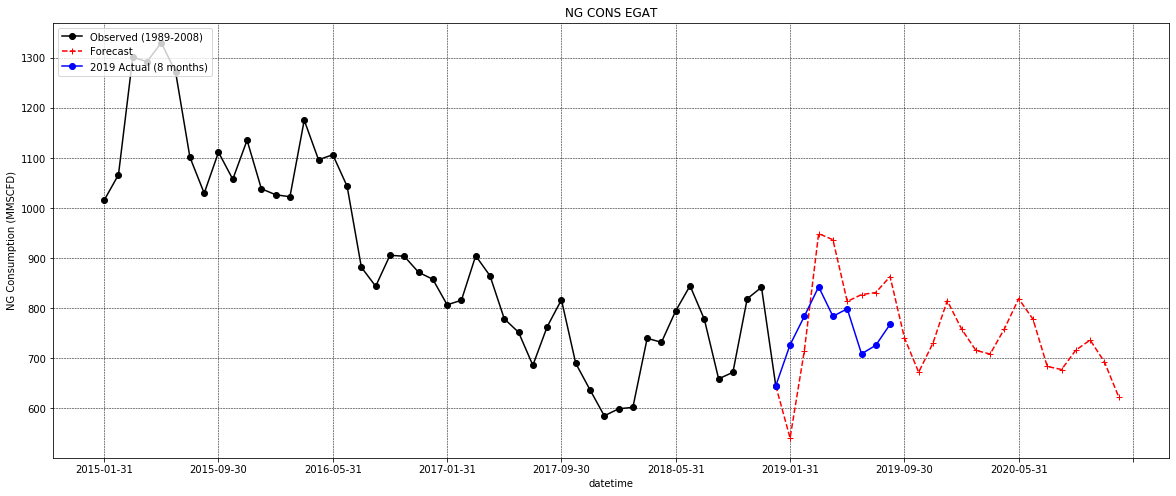

In [520]:
fig = custom_plot_var_forc_from_df(test, forc_df, forcUpper_df, forcLower_df, joinData2_df, plot_actual=True, names='NG CONS EGAT', plot_stderr=False)

In [510]:
print('Forecast Accuracy of: NG CONS EGAT (Compare actual 8 months of 2019)')
accuracy_prod = forecast_accuracy(forc_df['NG CONS EGAT'][:6].values, joinData2_df['NG CONS EGAT'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: NG CONS EGAT (Compare actual 8 months of 2019)
MAPE :  56.1371
ME :  799.7484
MAE :  799.7484
MPE :  50.4748
RMSE :  814.4504
CORR :  0.1172


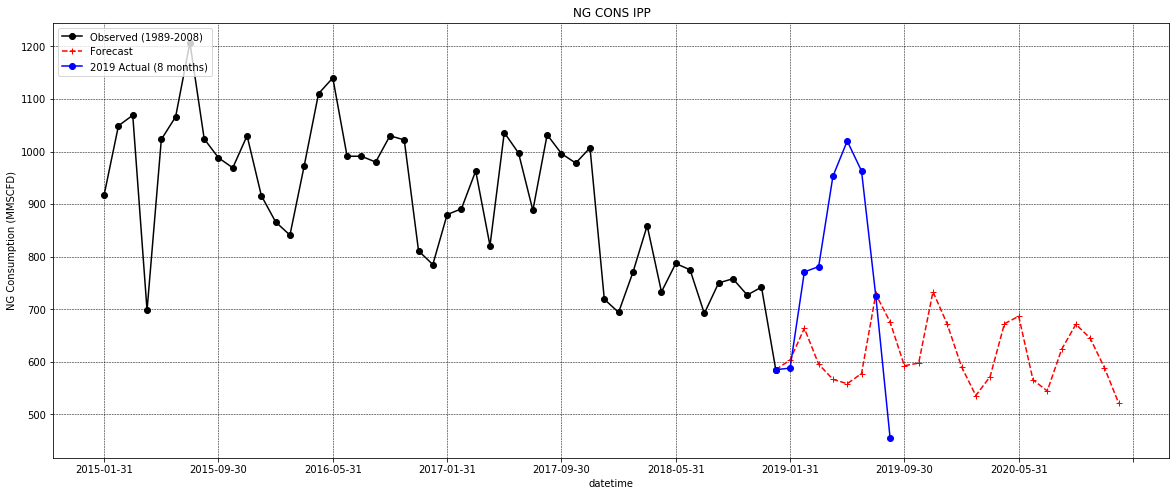

In [521]:
fig = custom_plot_var_forc_from_df(test, forc_df, forcUpper_df, forcLower_df, joinData2_df, plot_actual=True, names='NG CONS IPP', plot_stderr=False)

In [512]:
print('Forecast Accuracy of: NG CONS IPP (Compare actual 8 months of 2019)')
accuracy_prod = forecast_accuracy(forc_df['NG CONS IPP'][:6].values, joinData2_df['NG CONS IPP'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: NG CONS IPP (Compare actual 8 months of 2019)
MAPE :  7.1605
ME :  669.7647
MAE :  669.7647
MPE :  -6.1278
RMSE :  675.886
CORR :  0.8187


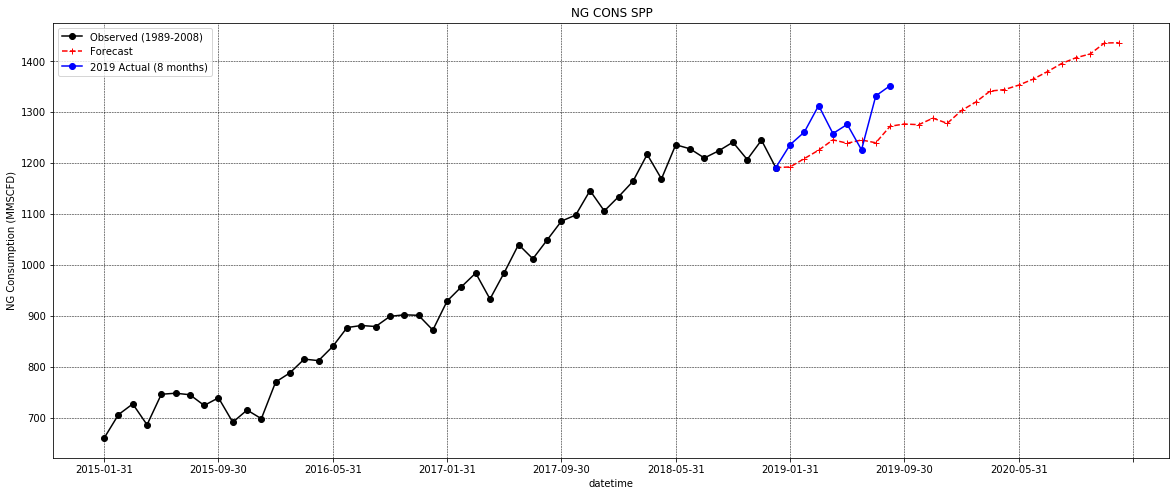

In [522]:
fig = custom_plot_var_forc_from_df(test, forc_df, forcUpper_df, forcLower_df, joinData2_df, plot_actual=True, names='NG CONS SPP', plot_stderr=False)

In [514]:
print('Forecast Accuracy of: NG CONS SPP (Compare actual 8 months of 2019)')
accuracy_prod = forecast_accuracy(forc_df['NG CONS SPP'][:6].values, joinData2_df['NG CONS SPP'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: NG CONS SPP (Compare actual 8 months of 2019)
MAPE :  18.8315
ME :  1226.9381
MAE :  1226.9381
MPE :  3.1322
RMSE :  1230.7645
CORR :  -0.0094
